In [1]:
# For running the notebook on Google Colab, uncomment the following lines of code.

# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/CSMM-pipeline

# Statistical Analysis

After training the machine learning classifiers, we would like to use them to quantify our variables of interest (e.g., argumentation strategy) in the entire corpus. Even when classifiers meet certain quality criteria (e.g., high F1 score), some residual classification error remains. As such, variables quantified through machine learning can confound the statistical analyses.

In the following we introduce two techniques for preventing bias through machine classification in the statistical analyses, especially for <b>settings in which we would like to compare between two groups</b> (e.g., opinion strategy vs. no opinion) and in which groups are not randomly assigned, but identified through classifier labels.

## Accounting for Classifier Inaccuracy

For the following example, let's assume that we'd like to investigate whether tweets containing argumentation strategy opinion are also less hateful than tweets not containing opinion. We will need to define a classifier threshold to distinguish tweets with "opinion" from tweets with "no opinion".

One possibility is to select tweets as "opinion" for which the classifier probability is the highest for "opinion" compared to other classes. However, this would also label tweets as opinion for which the classifier is actually not very confident (e.g., "construct": 0.25, "opin": 0.30, "sarc": 0.25, "leave_fact": 0.18, "other": 0.02).

For the group comparison, we would rather like to only classify tweets as opinion for which the classifier is confident. In the following, we demonstrate how to tune the classification threshold against classifier F1 scores to make both classes maximally distinct.

## Focus Group Comparisons: Binarizing Classes

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report
from scipy.special import softmax
import os

In [3]:
src = "data"

First, we need to find the best performing model for a certain classification task overall (e.g., classifying argumentation strategy). Remember: We trained models on five different data splits for the same task to select the best out of five (see also notebook on model training).

In [4]:
def get_best_split(src, model, class_dict):
    """
    Finds the split that performs best in terms of macro avg F1 score over
    all classes (for argumentation startegy) and returns the split number.
    Assume we have already generated files with predictions of each of the
    models (splits) for our test set (here in directory "data/preds_strategy_test").
    """
    pred_files = os.listdir(Path(src, "preds_strategy_test"))
    pred_files = [f for f in pred_files if model in f]
    pred_files.sort()
    
    performances = pd.DataFrame()
    for split in range(5):
        # load raw predictions of classifier
        preds = pd.read_csv(
            Path(src, "preds_strategy_test", pred_files[split])
        )
        preds = preds.rename(columns={"label": "true_label"})
        
        # calculate performance metrics including F1 score
        report = classification_report(
            preds["true_label"], 
            preds["pred_label"], 
            output_dict=True,
            zero_division = 0
        )

        # store model number and F1 score in "performances" dataframe
        row = pd.DataFrame({
            "split": [split], 
            "f1-score": [report["macro avg"]["f1-score"]]
        })
        
        performances = pd.concat([performances, row]).reset_index(drop=True)

    # find best split based on F1 score
    best_split = int(performances.loc[performances.idxmax()["f1-score"]]["split"])
    
    return best_split

After finding the best performing model for argumentation strategy overall, we scan through different thresholds to distinguish "opinion" and "not opinion", calculating the F1 score with respect to the human annotated test set for each of those thresholds. We would like to select the threshold for which the F1 score is the highest to make groups "opinion" and "not opinion" maximally distinct. We will consider all classifier thresholds between 0 and 1 in increments of 0.01. The table below illustrates this principle with a toy example:

| Tweet        | Human       | Classifier probability | Threshold 0.73 | Threshold 0.74 |
| ------------ | ----------- | ---------------------- | -------------- | -------------- |
| Tweet A      | opinion     | .742                   | opinion        | opinion        |
| Tweet B      | not opinion | .737                   | opinion        | not opinion    |
| Tweet C      | opinion     | .741                   | opinion        | opinion        |
| Tweet D      | opinion     | .739                   | opinion        | not opinion    |
| Tweet E      | not opinion | .725                   | not opinion    | not opinion    |
| Tweet F      | opinion     | .749                   | opinion        | opinion        |
| Tweet G      | not opinion | .741                   | opinion        | opinion        |
| Tweet H      | not opinion | .722                   | not opinion    | not opinion    |
| **F1 score** |             |                        | **.8**         | .75            |

<i>Note.</i> For each group comparison, we increment classifier thresholds by 0.01 computing F1 scores for each of those thresholds according to the human annotated test set. Here, only two out of many tested thresholds are illustrated. To separate the dataset into groups, we would choose the threshold maximizing the F1 score, here 0.73 for argumentation strategy "opinion" (toy example).

In [5]:
# Let's define some more helper functions.

def scan_thresholds(src, model, class_dict, split):
    """
    Scans different thresholds for prediction probabilities to binarize 
    predictions. Returns the classifier performances for each threshold.
    """
    # load raw predictions of classifier
    pred_files = os.listdir(Path(src, "preds_strategy_test"))
    pred_files = [f for f in pred_files if model in f]
    pred_files.sort()
    pred_cols = [f"raw_pred_{i}" for i in range(len(class_dict))]
    preds = pd.read_csv(
        Path(src, "preds_strategy_test", pred_files[split])
    )
    # apply softmax to turn raw predictions into probabilities
    preds[pred_cols] = softmax(preds[pred_cols], axis=1)
    preds = preds.rename(columns={"label": "true_label"})

    # loop over thresholds from 0 to 1 in increments of 0.01
    thresholds = np.arange(0, 1, 0.01)
    performances = pd.DataFrame()
    for label in range(len(class_dict)):  # test all classes
        for threshold in thresholds:
            true_label = np.where(preds["true_label"] == label, 1, 0)
            pred_label = np.where(preds[f"raw_pred_{label}"] > threshold, 1, 0)
            # calculate metrics
            report = classification_report(
                true_label, 
                pred_label, 
                output_dict=True,
                zero_division = 0
            )

            # store results in dataframe
            row = pd.DataFrame({
                "label": [label],
                "threshold": [threshold],
                "precision": [report["macro avg"]["precision"]],
                "recall": [report["macro avg"]["recall"]],
                "f1-score": [report["macro avg"]["f1-score"]]
            })
            
            performances = pd.concat([performances, row])

    performances = performances.reset_index(drop=True)

    return performances

In [6]:
def get_optimal_thresholds(performances, class_dict):
    """
    Returns the optimum threshold for every class (in argmentation strategy)
    including the F1 score, precision and recall of the classifier in a
    one vs. all prediction scenario.
    """
    optima = pd.DataFrame()
    for label in class_dict.keys():
        subset = performances[performances["label"] == label]  # only keep entries in the "performances" dataframe with current label
        idx = subset.idxmax()["f1-score"]  # get maximum F1 score
        optimum = subset.loc[idx]  # locate optimal row in df
        optima = pd.concat([optima, pd.DataFrame(optimum).transpose()])  # add to overall df collecting optimal thresholds

    optima["label"] = optima["label"].astype(int)
    optima["label"] = optima["label"].replace(class_dict)  # substitute numerical with natural language labels
    optima = optima.rename(columns={"threshold": "optimum_threshold"})

    return optima


In [7]:
# Applying the functions, we can now search for the optimum threshold to binarize predictions
# for all classes in argumentation strategy in a one vs. all other classes scenario.

model = "twitter-xlm-roberta-base_epochs-100_batchsize-64_strategy"
class_dict = {
    0: "construct",
    1: "opin",
    2: "sarc",
    3: "leave_fact",
    4: "other",
}

In [8]:
# First, we retrieve the best out of five models for argumentation strategy overall.
best_split = get_best_split(src, model, class_dict)
print(f"Best model for argumentation startegy overall is split {best_split}.")
# Second, we scan through the thresholds in increments of 0.01 for each of opinion - not opinion, construct - not construct, etc.
performances = scan_thresholds(src, model, class_dict, best_split)
# Third, we retrieve the thresholds where the F1 score is the highest for each of the classes.
optima = get_optimal_thresholds(performances, class_dict)

Best model for argumentation startegy overall is split 3.


In [9]:
cols = ["label", "optimum_threshold", "f1-score", "precision", "recall"]
optima = optima[cols].reset_index(drop=True)

In [10]:
# display optimal thresholds
optima

,label,optimum_threshold,f1-score,precision,recall
0,construct,0.27,0.739928,0.713683,0.780287
1,opin,0.40,0.782448,0.789912,0.776485
2,sarc,0.28,0.670686,0.663035,0.679363
3,leave_fact,0.47,0.839352,0.840664,0.838074
4,other,0.31,0.884361,0.907378,0.866389


## Focus Group Comparisons: Classifier Based Bootstrapping

While tuning the classifier threshold solves the problem of dividing observations into classes, the classifiers are in principle still imprecise. Therefore, we propose incorporating the classifier's false positive and false negative rates in the bootstrapping procedure for calculating the confidence intervals in the statistical analaysis.

For example, let's assume the false positive and false negative rates of our classifier for opinion are 0.25 and 0.125, respectively. We then flip the label "opinion" to "no opinion" in 12.5\% of the cases, and the label "no opinion" to "opinion" in 25\% of the cases. This way, we draw multiple samples with replacement, repeating the analysis (here a t-test) to compute confidence intervals for our estimators (here t-statistic and Cohen's d). These confidence intervals are inflated and make the statistical conclusions robust to the noise of the classifier.

The following table illustrates the principle on a toy example:

| Tweet                  | Classifier Label | Sample 1        | Sample 2        | Sample 3        |
| :--------------------- | :--------------- | :-------------- | :-------------- | :-------------- |
| Tweet A                | opinion          | **not opinion** | opinion         | opinion         |
| Tweet B                | not opinion      | **opinion**     | not opinion     | not opinion     |
| Tweet C                | opinion          | opinion         | opinion         | **not opinion** |
| Tweet D                | opinion          | opinion         | **not opinion** | opinion         |
| Tweet E                | not opinion      | not opinion     | **opinion**     | **opinion**     |
| Tweet F                | opinion          | opinion         | opinion         | opinion         |
| Tweet G                | not opinion      | not opinion     | not opinion     | **opinion**     |
| Tweet H                | not opinion      | **opinion**     | **opinion**     | not opinion     |
| Regression coefficient |                  | .45             | .49             | .37             |
| Confidence interval    |                  |                 | [.37 - .49]     |                 |

<i>Note.</i> We flip labels according to the false negative rates ("opinion" to "not opinion") and false positive rates ("not opinion" to "opinion") of our classifier. Here, flipped labels are marked in bold. For each sample, we compute coefficients resulting in an overall confidence interval over all samples. The approach makes the group comparison robust to the errors of the classifier.

In the following, let's apply this procedure to our hypothetical question: Are tweets containing opinion also less hateful compared to tweets without opinion?

In [11]:
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import confusion_matrix
from scipy import stats
import matplotlib.pyplot as plt

/Users/alinaherderich/anaconda3/envs/CSMM-pipeline/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# We'll load a sample corpus of 1000 unlabeled tweets for our example.
sample_corpus = pd.read_csv("data/sample_pool.csv", sep=";", usecols=["tweet_id", "text"])
sample_corpus = sample_corpus[:1000]
sample_corpus.head()

,tweet_id,text
0,960158527582097408,Das ist so nicht richtig.
1,837717128480444418,Man sollte die Drohungen von der ISIS Gruppe e...
2,1082375206319128576,Gerade gibt's in den USA eine Ausschreibung fü...
3,1013645930443235328,Horst los! Das Netz hat dein Angebot voll ange...
4,1031345564649172992,Und was jetzt? Müssen wir uns jetzt neben dem ...


In [13]:
# Now, we need to classify tweets with opinion versus no opinion (binary variable, independent variable) and extract a
# hate score for each of the tweets (continuous variable, dependent variable). For no/opinion, let's use our classifier
# from "training on confident examples" (notebook model training). For hate, we'll use a pre-trained German BERT from
# Huggingface that was finetuned on a German hate speech dataset (see here: https://epub.oeaw.ac.at/0xc1aa5576_0x003a10d2.pdf).
MODEL_STRATEGY = "finetuned_models/twitter-xlm-roberta-base_split-1"
MODEL_HATE = "deepset/bert-base-german-cased-hatespeech-GermEval18Coarse"

In [14]:
def inference(feature="opinion"):
    """
    Runs classifiers specified in MODEL_STRATEGY and MODEL_HATE over
    the sample corpus, respectively.

    Parameter "feature" takes values "opinion" or "hate".
    """
    # check if GPU is available to run the models
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():  # for Apple Silicon
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")

    # load models
    if feature == "opinion":
        tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base")
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_STRATEGY).to(device)
    if feature == "hate":
        tokenizer = AutoTokenizer.from_pretrained(MODEL_HATE)
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_HATE).to(device)

    # predict
    preds = []
    
    for t in tqdm(sample_corpus.text.to_list()):
        inputs = tokenizer(t, truncation=True, padding=True, max_length=180, return_tensors="pt").to(device)
    
        with torch.no_grad():
            logits = model(**inputs).logits
    
        if device == "mps":
            torch.mps.empty_cache()

        preds.append(softmax(logits.cpu())[0][1])  # both "opinion" and "hate" correspond to label 1

    return preds

In [15]:
# infer opinion score for tweets and add as column to dataframe
opinion_probs = inference(feature="opinion")
sample_corpus["opinion_probs"] = opinion_probs

Using device: mps


Loading weights: 100%|█| 201/201 [00:00<00:00, 1848.23it/s, Materializing param=
100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 65.03it/s]


In [16]:
# infer hate score for tweets and add as column to dataframe
hate = inference(feature="hate")
sample_corpus["hate"] = hate

Using device: mps


Loading weights: 100%|█| 201/201 [00:00<00:00, 1863.13it/s, Materializing param=
100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 89.93it/s]


In [17]:
sample_corpus.head()

,tweet_id,text,opinion_probs,hate
0,960158527582097408,Das ist so nicht richtig.,0.183180,0.088122
1,837717128480444418,Man sollte die Drohungen von der ISIS Gruppe e...,0.180528,0.014237
2,1082375206319128576,Gerade gibt's in den USA eine Ausschreibung fü...,0.183795,0.009567
3,1013645930443235328,Horst los! Das Netz hat dein Angebot voll ange...,0.183041,0.014625
4,1031345564649172992,Und was jetzt? Müssen wir uns jetzt neben dem ...,0.183387,0.008012


In [18]:
# Usually, we would now use our threshold inferred from the data as demonstrated above
# to assign tweets to the "opinion" versus "no opinion" class. However,
# since we are working with a (very bad performing) preliminary classifier, for demonstration
# purposes, let's set the cut-off score arbitrarily such that approximately half of the tweets
# are assigned to "opinion" and "no opinion".
sample_corpus["opinion_binary"] = np.array(opinion_probs) > 0.221  # arbitrary cut-off for demonstration only!
sample_corpus["opinion_binary"] = sample_corpus["opinion_binary"].replace({False: 0, True: 1})
sample_corpus.head()

/var/folders/pr/ww_9n13j1n3b2xg6jrj22hq40000gn/T/ipykernel_49615/2656433866.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sample_corpus["opinion_binary"] = sample_corpus["opinion_binary"].replace({False: 0, True: 1})


,tweet_id,text,opinion_probs,hate,opinion_binary
0,960158527582097408,Das ist so nicht richtig.,0.183180,0.088122,0
1,837717128480444418,Man sollte die Drohungen von der ISIS Gruppe e...,0.180528,0.014237,0
2,1082375206319128576,Gerade gibt's in den USA eine Ausschreibung fü...,0.183795,0.009567,0
3,1013645930443235328,Horst los! Das Netz hat dein Angebot voll ange...,0.183041,0.014625,0
4,1031345564649172992,Und was jetzt? Müssen wir uns jetzt neben dem ...,0.183387,0.008012,0


In [19]:
# To calculate the false positive (FPR) and false negative rate (FNR), we will rely on the 
# true and predicted scores for opinion on our test set for the best performing model
# (see above). We will need the FPR and FNR for bootstrapping statistical parameters
# in the group comparisons later.
testset = pd.read_csv("data/preds_strategy_test/twitter-xlm-roberta-base_epochs-100_batchsize-64_strategy_split-3_preds.csv")
testset = testset[["label", "pred_label"]].rename(columns={"label": "true_label"})
testset.head()

,true_label,pred_label
0,1,1
1,3,3
2,1,3
3,3,1
4,1,1


In [20]:
confusion = confusion_matrix(testset.true_label, testset.pred_label)
confusion

array([[ 26,  19,   0,  11,   6],
       [ 16, 133,   1,  28,   9],
       [ 10,  11,   2,   8,   6],
       [  3,  25,   1, 131,   4],
       [  9,  15,   0,   7, 113]])

In [21]:
TP = confusion[1, 1]
FN = confusion[1, :].sum() - TP
FP = confusion[:, 1].sum() - TP
TN = len(testset) - FN - FN - FP

FPR = FP / (FP + TN)  # 0.14
FNR = FN / (FN + TP)  # 0.29

In [22]:
# Now, we can bootstrap our statistics: t and Cohen's d.

def cohens_d(A, B):
    """
    Calculates Cohen's d as effect size for the t test of independent samples
    A and B with different sample sizes and different variances.
    """
    n1 = len(A)
    n2 = len(B)
    var1 = A.var()
    var2 = B.var()
    mean1 = A.mean()
    mean2 = B.mean()
    
    sd_pooled = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    
    d = (mean1 - mean2) / sd_pooled

    return d

In [23]:
# We will run the t-test for a thousand times flipping the label opinion to no opinion based
# on the false positive rate and no opinion to opinion on the false negative rate. We'll collect
# the t statistic and the Cohen's d for each of those runs to plot them afterwards.
BOOT = 1000

summary_t = []
summary_d = []

for i in tqdm(range(BOOT)):
    # sample indices for flipping labels
    flip_positive = pd.Series(sample_corpus.index[sample_corpus.opinion_binary == 1]).sample(frac=FPR, random_state=i)
    flip_negative = pd.Series(sample_corpus.index[sample_corpus.opinion_binary == 0]).sample(frac=FNR, random_state=i)

    # flip labels
    temp = sample_corpus.copy()
    temp.loc[flip_positive, "opinion_binary"] = 0
    temp.loc[flip_negative, "opinion_binary"] = 1

    # compute statistics
    t, p = stats.ttest_ind(temp[temp.opinion_binary == 0].hate, temp[temp.opinion_binary == 1].hate)
    d = cohens_d(temp[temp.opinion_binary == 0].hate, temp[temp.opinion_binary == 1].hate)

    summary_t.append(t)
    summary_d.append(d)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 769.48it/s]


Text(0, 0.5, 'frequency')

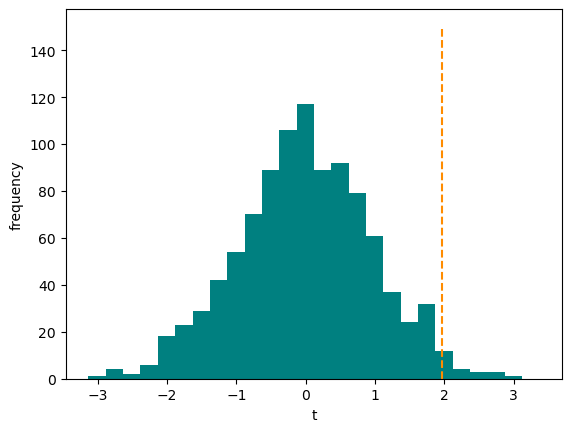

In [24]:
# Histogram of t statistics
# The vertical line denotes the cut of score for an alpha level of 0.05.
# Here, we can make the robust conclusion that the two groups (opinion vs.
# no opinion) differ only when all bootstrapped tests exceed the significance level.
plt.hist(summary_t, bins=np.arange(np.min(summary_t), np.max(summary_t), 0.25), color='teal')
plt.vlines(1.96, ymin=0, ymax=150, color='darkorange', linestyle='--')
plt.xlabel('t')
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

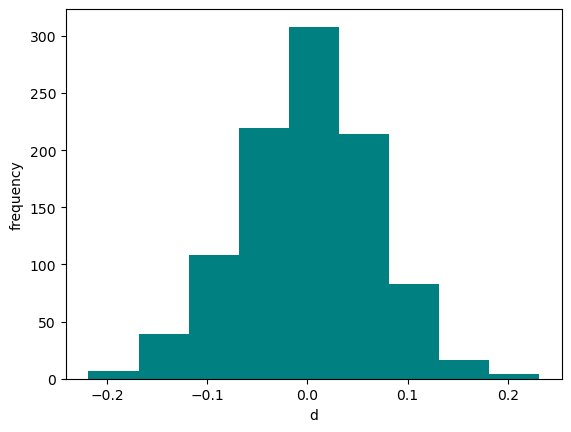

In [25]:
# Cohen's d denotes the size and direction of the difference between
# the two groups (opinion vs. no opinion). Note: These results are not
# reliable based on our very bad performing classifiers that we used to
# extract the variables and just for illustration purposes.
plt.hist(summary_d, bins=np.arange(np.min(summary_d), np.max(summary_d), 0.05), color='teal')
plt.xlabel('d')
plt.ylabel('frequency')

<b>Congratulations, you've reached the end of the tutorial!</b>

If you'd like to dive deeper into the concepts discussed in this tutorial, please refer to the accompanying publication: Herderich, A., Lasser, J., Galesic, M., Aroyehun, S., David, G., & Garland, J. (2026). Measuring complex constructs in large-scale text with computational social mixed methods. <i>BRM, under review</i>.